In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import warnings
import cProfile

from time import time

from astropy.stats import sigma_clip
from astropy.table import Table, Column, vstack
from scipy.ndimage.filters import gaussian_filter

import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from astroML.stats import binned_statistic_2d

from asap import io
from asap import smf 
from asap import config
from asap import fitting
from asap import ensemble
from asap import plotting
from asap import predictions
from asap.parameters import AsapParams
from asap.likelihood import ln_likelihood, ln_probability
from asap.predictions import (predict_mstar_basic, predict_smf, predict_mhalo,
                              predict_dsigma_profiles, make_model_predictions)

plt.rc('text', usetex=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Important Statistics of the UniverseMachine Catalog

In [2]:
test_dir = '../model'

# The configuration file
config_file = os.path.join(test_dir, 'asap_test_1.yaml')

# Initialize the model, load the data
cfg, params, obs_data, um_data = fitting.initial_model(config_file, verbose=True)

um_mock = um_data['um_mock']

um_mock_cen = um_mock[um_mock['upid'] == -1]

# Running model: asap_test_1
#    Will use emcee as sampler ...
#    Use   256 walkers with    snooker moves for   180 x  3 steps of burn-in
#    Use   256 walkers with        kde moves for   400 steps of sampling

# Observations:
# Galaxy catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# DSigma results: s16a_wide2_dsigma_logm11.6_12_bins.npy
# SMF of inner Mstar: s16a_wide2_massive_smf_m10_11.6.npy
# SMF of total Mstar: s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: s16a_wide2_massive_smf_mmax_m10_cov.npy
# Reference SMF: primus_smf_z0.3_0.4.fits
# Column of inner Mstar: logm_10
# Column of total Mstar: logm_max

# UniverseMachine:
# Galaxy catalog : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_short.npy
# DSigma results : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_50m_r_0.08_50_22bins.npy
# Volumn of the simulation:    205348196.23 Mpc^3
# Halo mass : logmh_host
# Stellar mass : logms_tot
# There are 12 DSigma profiles in this sample
# SMF for total stella

In [3]:
um_mock_cen.dtype

dtype([('halo_id', '<i8'), ('upid', '<i8'), ('sm', '<f8'), ('icl', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('mtot_galaxy', '<f8'), ('mstar_mhalo', '<f8'), ('logms_gal', '<f8'), ('logms_icl', '<f8'), ('logms_tot', '<f8'), ('logms_halo', '<f8'), ('logmh_vir', '<f8'), ('logmh_peak', '<f8'), ('logmh_host', '<f8'), ('frac_cen_tot', '<f8'), ('frac_ins_cen', '<f8'), ('frac_exs_cen', '<f8')])

### Relation between central galaxy mass fraction and total stellar mass in a halo

In [17]:
logms_halo = um_mock_cen['logms_halo']

logms_cen = um_mock_cen['logms_tot']

logmh_vir = um_mock_cen['logmh_vir']

# Halo mass bins
logms_bin = np.linspace(11.0, 13.5, 15)

# For central
idx_logms = np.digitize(logms_halo, logms_bin)

logms_avg = [np.nanmean(logms_halo[idx_logms == k]) for k in range(len(logms_bin))]

mcen_avg = [np.nanmean(logms_cen[idx_logms == k]) for k in range(len(logms_bin))]

mcen_std = [np.nanstd(logms_cen[idx_logms == k]) for k in range(len(logms_bin))]

Text(0.5, 0, '$\\log M_{\\star,\\ \\mathrm{Cen}}$')

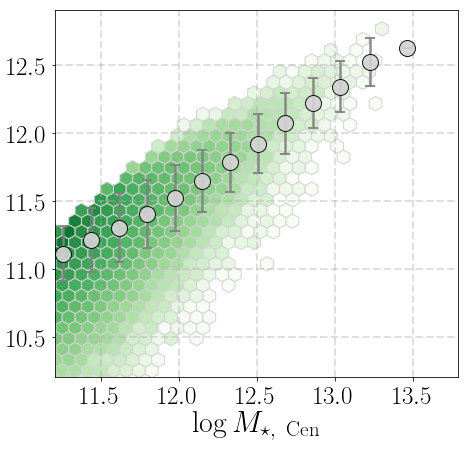

In [16]:
fig_0 = plt.figure(figsize=(7, 6))
fig_0.subplots_adjust(left=0.195, right=0.995, bottom=0.145, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_0.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

#ax1.xaxis.set_ticks([13.4, 13.8, 14.2, 14.6])

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

# Show the density distribution of central galaxies using hexbin
ax1.hexbin(logms_halo, logms_cen, 
           gridsize=[60, 30], cmap='Greens', edgecolor='lightgray', 
           alpha=1.0, mincnt=1, bins='log')

ax1.errorbar(logms_avg, mcen_avg, yerr=np.asarray(mcen_std), fmt='o', 
             ecolor='gray', elinewidth=2.5, capsize=5, capthick=2.0,
             color='lightgray', markersize=16, alpha=0.9,
             markeredgecolor='k')

ax1.set_xlim(11.21, 13.79)
ax1.set_ylim(10.2, 12.9)

ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Halo}}$', fontsize=30)
ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Cen}}$', fontsize=30)
#ax1.set_ylabel(r'$\delta_{\rm Cen}$', fontsize=32)

#_ = ax1.text(0.55, 0.90, r"$\mathrm{UniverMachine}$", fontsize=28, transform=ax1.transAxes)
#_ = ax1.text(0.65, 0.80, r"$\mathrm{SMDPL}$", fontsize=28, transform=ax1.transAxes)

In [20]:
logms_halo = um_mock_cen['logms_halo']

logms_cen = um_mock_cen['logms_tot']

logmh_vir = um_mock_cen['logmh_vir']

# Halo mass bins
logmh_bin = np.linspace(13.0, 15.0, 10)

# For central
idx_logmh = np.digitize(logmh_vir, logmh_bin)

logmh_avg = [np.nanmean(logmh_vir[idx_logmh == k]) for k in range(len(logmh_bin))]

mcen_avg = [np.nanmean(logms_cen[idx_logmh == k]) for k in range(len(logmh_bin))]

mcen_std = [np.nanstd(logms_cen[idx_logmh == k]) for k in range(len(logmh_bin))]

Text(0.5, 0, '$\\log M_{\\star,\\ \\mathrm{Cen}}$')

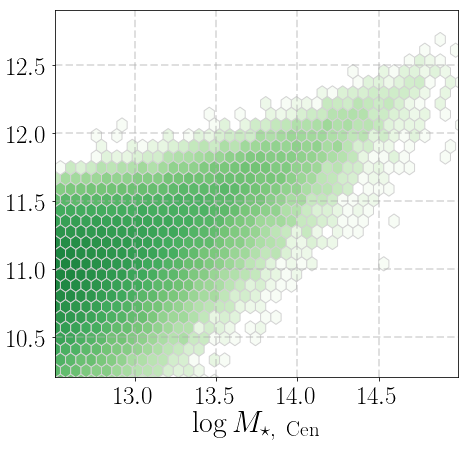

In [19]:
fig_0 = plt.figure(figsize=(7, 6))
fig_0.subplots_adjust(left=0.195, right=0.995, bottom=0.145, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_0.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

#ax1.xaxis.set_ticks([13.4, 13.8, 14.2, 14.6])

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

# Show the density distribution of central galaxies using hexbin
ax1.hexbin(logmh_vir, logms_cen, 
           gridsize=[60, 30], cmap='Greens', edgecolor='lightgray', 
           alpha=1.0, mincnt=1, bins='log')

ax1.errorbar(logms_avg, fcen_avg, yerr=np.asarray(fcen_std), fmt='o', 
             ecolor='gray', elinewidth=2.5, capsize=5, capthick=2.0,
             color='lightgray', markersize=16, alpha=0.9,
             markeredgecolor='k')

ax1.set_xlim(12.51, 14.99)
ax1.set_ylim(10.2, 12.9)

ax1.set_xlabel(r'$\log M_{\mathrm{Vir}}$', fontsize=30)
ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Cen}}$', fontsize=30)
#ax1.set_ylabel(r'$\delta_{\rm Cen}$', fontsize=32)

#_ = ax1.text(0.55, 0.90, r"$\mathrm{UniverMachine}$", fontsize=28, transform=ax1.transAxes)
#_ = ax1.text(0.65, 0.80, r"$\mathrm{SMDPL}$", fontsize=28, transform=ax1.transAxes)

In [21]:
logms_halo = um_mock_cen['logms_halo']

frac_cen = um_mock_cen['frac_cen_tot']

# Halo mass bins
logms_bin = np.linspace(11.0, 13.5, 15)

# For central
idx_logms = np.digitize(logms_halo, logms_bin)

logms_avg = [np.nanmean(logms_halo[idx_logms == k]) for k in range(len(logms_bin))]

fcen_avg = [np.nanmean(frac_cen[idx_logms == k]) for k in range(len(logms_bin))]

fcen_std = [np.nanstd(frac_cen[idx_logms == k]) for k in range(len(logms_bin))]

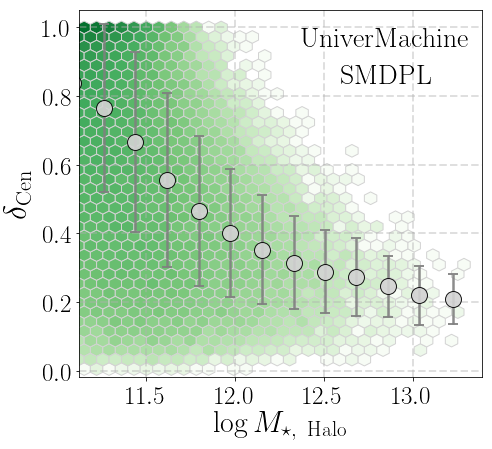

In [26]:
fig_0 = plt.figure(figsize=(7, 6))
fig_0.subplots_adjust(left=0.195, right=0.995, bottom=0.145, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_0.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

#ax1.xaxis.set_ticks([13.4, 13.8, 14.2, 14.6])

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

# Show the density distribution of central galaxies using hexbin
ax1.hexbin(logms_halo, frac_cen, 
           gridsize=[70, 18], cmap='Greens', edgecolor='lightgray', 
           alpha=1.0, mincnt=1, bins='log')

ax1.errorbar(logms_avg, fcen_avg, yerr=np.asarray(fcen_std), fmt='o', 
             ecolor='gray', elinewidth=2.5, capsize=5, capthick=2.0,
             color='lightgray', markersize=16, alpha=0.9,
             markeredgecolor='k')

ax1.set_xlim(11.12, 13.39)
ax1.set_ylim(-0.02, 1.05)

ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Halo}}$', fontsize=30)
ax1.set_ylabel(r'$\delta_{\rm Cen}$', fontsize=32)

_ = ax1.text(0.55, 0.90, r"$\mathrm{UniverMachine}$", fontsize=28, transform=ax1.transAxes)
_ = ax1.text(0.65, 0.80, r"$\mathrm{SMDPL}$", fontsize=28, transform=ax1.transAxes)

In [27]:
fig_0.savefig('fig/figA1_a_new.pdf', dpi=110)

### Relation between central galaxy mass fraction and halo mass

In [5]:
logmh_vir = um_mock_cen['logmh_vir']

frac_cen = um_mock_cen['frac_cen_tot']

# Halo mass bins
logmh_bin = np.linspace(13.0, 15.0, 10)

# For central
idx_logmh = np.digitize(logmh_vir, logmh_bin)

logmh_avg = [np.nanmean(logmh_vir[idx_logmh == k]) for k in range(len(logmh_bin))]

fcen_avg = [np.nanmean(frac_cen[idx_logmh == k]) for k in range(len(logmh_bin))]

fcen_std = [np.nanstd(frac_cen[idx_logmh == k]) for k in range(len(logmh_bin))]

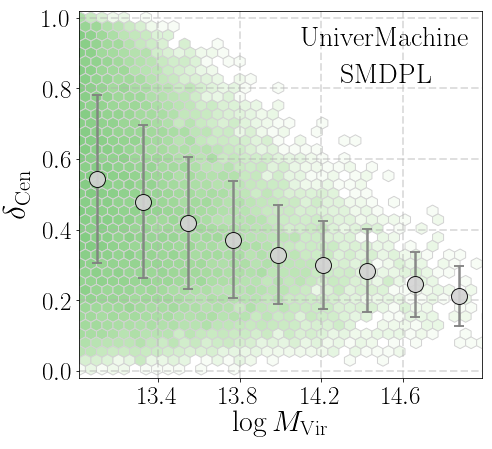

In [54]:
fig_1 = plt.figure(figsize=(7, 6))
fig_1.subplots_adjust(left=0.195, right=0.995, bottom=0.145, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_1.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

ax1.xaxis.set_ticks([13.4, 13.8, 14.2, 14.6])

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

# Show the density distribution of central galaxies using hexbin
ax1.hexbin(logmh_vir, frac_cen, 
           gridsize=[70, 20], cmap='Greens', edgecolor='lightgray', 
           alpha=1.0, mincnt=1, bins='log')

ax1.errorbar(logmh_avg, fcen_avg, yerr=np.asarray(fcen_std), fmt='o', 
             ecolor='gray', elinewidth=2.5, capsize=5, capthick=2.0,
             color='lightgray', markersize=16, alpha=0.9,
             markeredgecolor='k')

ax1.set_xlim(13.01, 14.99)
ax1.set_ylim(-0.02, 1.02)

ax1.set_xlabel(r'$\log M_{\mathrm{Vir}}$', fontsize=30)
ax1.set_ylabel(r'$\delta_{\rm Cen}$', fontsize=32)

_ = ax1.text(0.55, 0.90, r"$\mathrm{UniverMachine}$", fontsize=28, transform=ax1.transAxes)
_ = ax1.text(0.65, 0.80, r"$\mathrm{SMDPL}$", fontsize=28, transform=ax1.transAxes)

### Relations between in-situ and ex-situ fractions with halo mass

In [6]:
frac_ins = um_mock_cen['frac_ins_cen']
frac_exs = um_mock_cen['frac_exs_cen']

fins_avg = [np.nanmean(frac_ins[idx_logmh == k]) for k in range(len(logmh_bin))]
fins_std = [np.nanstd(frac_ins[idx_logmh == k]) for k in range(len(logmh_bin))]

fexs_avg = [np.nanmean(frac_exs[idx_logmh == k]) for k in range(len(logmh_bin))]
fexs_std = [np.nanstd(frac_exs[idx_logmh == k]) for k in range(len(logmh_bin))]

/usr/local/lib/python3.7/site-packages/astroML/stats/_binned_statistic.py:356: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Text(0, 0.5, '$\\delta_{\\rm ins}\\ \\mathrm{or}\\ \\delta_{\\rm exs}$')

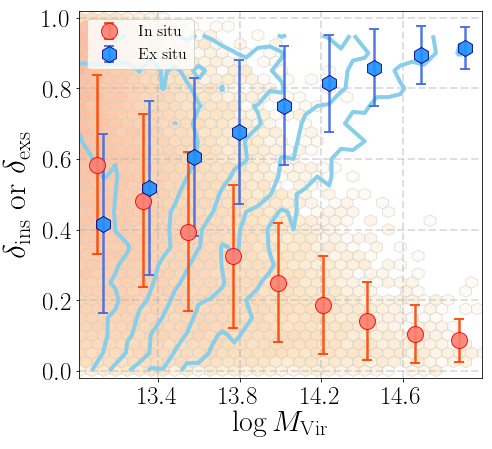

In [53]:
fig_2 = plt.figure(figsize=(7, 6))
fig_2.subplots_adjust(left=0.195, right=0.995, bottom=0.145, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_2.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

ax1.xaxis.set_ticks([13.4, 13.8, 14.2, 14.6])

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

# Show the density distribution of central galaxies using hexbin
ax1.hexbin(logmh_vir, frac_ins, 
           gridsize=[65, 20], cmap='OrRd', edgecolor='lightgray', 
           alpha=0.6, mincnt=1, bins='log')

z_stats, x_edges, y_edges = binned_statistic_2d(
    logmh_vir, frac_exs, frac_ins, 'count', bins=(65, 20))

CT = ax1.contour(x_edges[:-1], y_edges[:-1], gaussian_filter(z_stats.T, 0.25),
                 5, linewidths=4, linestyles='solid', 
                 colors=['skyblue'],
                 levels=[5, 20, 50, 100, 200],
                 extend='neither')

ax1.errorbar(logmh_avg, fins_avg, yerr=np.asarray(fins_std), fmt='o', 
             ecolor='orangered', elinewidth=2.5, capsize=5, capthick=2.0,
             color='salmon', markersize=16, alpha=0.9,
             markeredgecolor='r', label=r'$\mathrm{In\ situ}$')

ax1.errorbar(np.asarray(logmh_avg) + 0.03, fexs_avg, yerr=np.asarray(fexs_std), fmt='h', 
             ecolor='royalblue', elinewidth=2.5, capsize=5, capthick=2.0,
             color='dodgerblue', markersize=16, alpha=0.9,
             markeredgecolor='navy', label=r'$\mathrm{Ex\ situ}$')

ax1.legend(loc='best', fontsize=16)

ax1.set_xlim(13.01, 14.99)
ax1.set_ylim(-0.02, 1.02)

ax1.set_xlabel(r'$\log M_{\mathrm{Vir}}$', fontsize=30)
ax1.set_ylabel(r'$\delta_{\rm ins}\ \mathrm{or}\ \delta_{\rm exs}$', fontsize=32)

### Save the figures

In [55]:
fig_1.savefig('fig/figA1_a.pdf', dpi=120)

fig_2.savefig('fig/figA1_b.pdf', dpi=120)

### Compare the scatter of in-situ and ex-situ mass at fixed halo mass

In [14]:
logm_ins = um_mock_cen['logms_gal']
logm_exs = um_mock_cen['logms_icl']
logmh_vir = um_mock_cen['logmh_vir']

logmh_bin = np.linspace(13.0, 15.0, 10)

mask_use = (np.isfinite(logm_ins) & np.isfinite(logm_exs) & np.isfinite(logmh_vir))

idx_logmh = np.digitize(logmh_vir[mask_use], logmh_bin)

mins_avg = [np.nanmean(logm_ins[mask_use][idx_logmh == k]) for k in range(len(logmh_bin))]
mins_std = [np.nanstd(logm_ins[mask_use][idx_logmh == k]) for k in range(len(logmh_bin))]

mexs_avg = [np.nanmean(logm_exs[mask_use][idx_logmh == k]) for k in range(len(logmh_bin))]
mexs_std = [np.nanstd(logm_exs[mask_use][idx_logmh == k]) for k in range(len(logmh_bin))]

print(mins_std)
print(mexs_std)

[0.4963299384288345, 0.40930178824816765, 0.4254796179568304, 0.4025182322911804, 0.41357386490908266, 0.3821247392714294, 0.41441255358718543, 0.5054199337289826, 0.4351586224324433, 0.26763132538093665]
[0.8690464981386429, 0.4824988767357792, 0.42160690979388094, 0.3624217234772527, 0.3294940906177333, 0.28106824741532943, 0.2580208418998792, 0.2508914204020412, 0.22817130928616097, 0.2126225760626283]


Text(0, 0.5, '$\\delta_{\\rm ins}\\ \\mathrm{or}\\ \\delta_{\\rm exs}$')

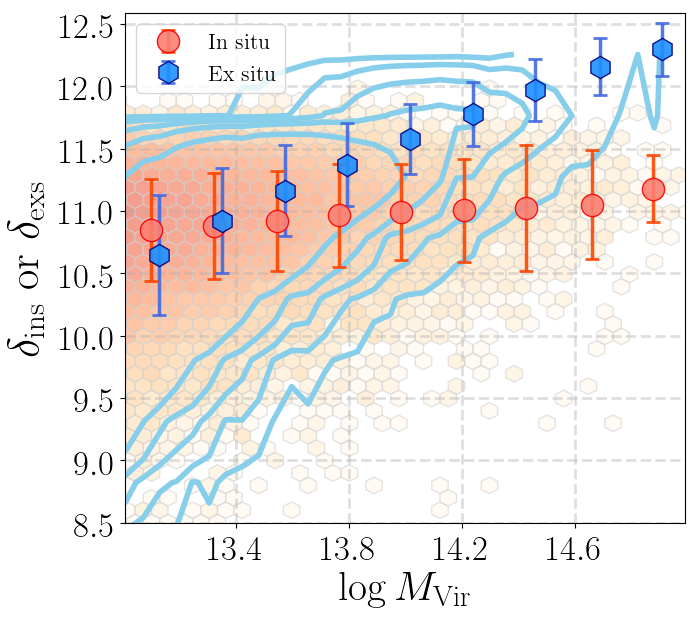

In [21]:
fig_3 = plt.figure(figsize=(7, 6))
fig_3.subplots_adjust(left=0.195, right=0.995, bottom=0.145, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_3.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

ax1.xaxis.set_ticks([13.4, 13.8, 14.2, 14.6])

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

# Show the density distribution of central galaxies using hexbin
ax1.hexbin(logmh_vir[mask_use], logm_ins[mask_use], 
           gridsize=[65, 35], cmap='OrRd', edgecolor='lightgray', 
           alpha=0.6, mincnt=1, bins='log')

z_stats, x_edges, y_edges = binned_statistic_2d(
    logmh_vir[mask_use], logm_exs[mask_use], logm_ins[mask_use], 'count', bins=(65, 20))

CT = ax1.contour(x_edges[:-1], y_edges[:-1], gaussian_filter(z_stats.T, 0.25),
                 5, linewidths=4, linestyles='solid', 
                 colors=['skyblue'],
                 levels=[5, 20, 50, 100, 200],
                 extend='neither')

ax1.errorbar(logmh_avg, mins_avg, yerr=np.asarray(mins_std), fmt='o', 
             ecolor='orangered', elinewidth=2.5, capsize=5, capthick=2.0,
             color='salmon', markersize=16, alpha=0.9,
             markeredgecolor='r', label=r'$\mathrm{In\ situ}$')

ax1.errorbar(np.asarray(logmh_avg) + 0.03, mexs_avg, yerr=np.asarray(mexs_std), fmt='h', 
             ecolor='royalblue', elinewidth=2.5, capsize=5, capthick=2.0,
             color='dodgerblue', markersize=16, alpha=0.9,
             markeredgecolor='navy', label=r'$\mathrm{Ex\ situ}$')

ax1.legend(loc='best', fontsize=16)

ax1.set_xlim(13.01, 14.99)
ax1.set_ylim(8.5, 12.59)

ax1.set_xlabel(r'$\log M_{\mathrm{Vir}}$', fontsize=30)
ax1.set_ylabel(r'$\delta_{\rm ins}\ \mathrm{or}\ \delta_{\rm exs}$', fontsize=32)

In [4]:
test_dir = '../model/'
model_str = 'final_6'

# The configuration file
config_file = os.path.join(test_dir, 'asap_test_%s.yaml' % model_str)

# Initialize the model, load the data
cfg, params, obs_data, um_data = fitting.initial_model(config_file, verbose=True)

um_mock = um_data['um_mock']

# Running model: asap_test_final_6
#    Will use emcee as sampler ...
#    Use   256 walkers with    snooker moves for   200 x  3 steps of burn-in
#    Use   256 walkers with        kde moves for 15000 steps of sampling

# Observations:
# Galaxy catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# DSigma results: s16a_wide2_dsigma_logm11.6_12_bins.npy
# SMF of inner Mstar: s16a_wide2_massive_smf_m10_11.6.npy
# SMF of total Mstar: s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: s16a_wide2_massive_smf_mmax_m10_cov.npy
# Reference SMF: primus_smf_z0.3_0.4.fits
# Column of inner Mstar: logm_10
# Column of total Mstar: logm_max

# UniverseMachine:
# Galaxy catalog : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_short.npy
# DSigma results : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_50m_r_0.08_50_22bins.npy
# Volumn of the simulation:    205348196.23 Mpc^3
# Halo mass : logmh_host
# Stellar mass : logms_tot
# There are 12 DSigma profiles in this sample
# SMF for total 

In [28]:
# Halo mass bins
logmh_bin = np.linspace(13.0, 15.0, 10)

um_mock_cen = um_mock[(um_mock['upid'] == -1) & (um_mock['logmh_peak'] >= 12.8) & (um_mock['logms_tot'] > 10.2)]
um_mock_sat = um_mock[(um_mock['upid'] != -1) & (um_mock['logmh_peak'] >= 12.8) & (um_mock['logms_tot'] > 10.2)]

# For central
logms_cen= um_mock_cen['logms_icl']
logmh_cen = um_mock_cen['logmh_peak']

idx_logmh_cen = np.digitize(logmh_cen, logmh_bin)
logmh_avg_cen = [np.nanmean(logmh_cen[idx_logmh_cen == k]) for k in range(len(logmh_bin))]
logms_avg_cen = [np.nanmean(logms_cen[idx_logmh_cen == k]) for k in range(len(logmh_bin))]
logms_std_cen = [np.nanstd(logms_cen[idx_logmh_cen == k]) for k in range(len(logmh_bin))]

# For satellites
logms_sat= um_mock_sat['logms_icl']
logmh_sat = um_mock_sat['logmh_peak']

idx_logmh_sat = np.digitize(logmh_sat, logmh_bin)
logmh_avg_sat = [np.nanmean(logmh_sat[idx_logmh_sat == k]) for k in range(len(logmh_bin))]
logms_avg_sat = [np.nanmean(logms_sat[idx_logmh_sat == k]) for k in range(len(logmh_bin))]
logms_std_sat = [np.nanstd(logms_sat[idx_logmh_sat == k]) for k in range(len(logmh_bin))]

Text(0, 0.5, '$\\log M_{\\star,\\ \\rm Ex\\ situ}$')

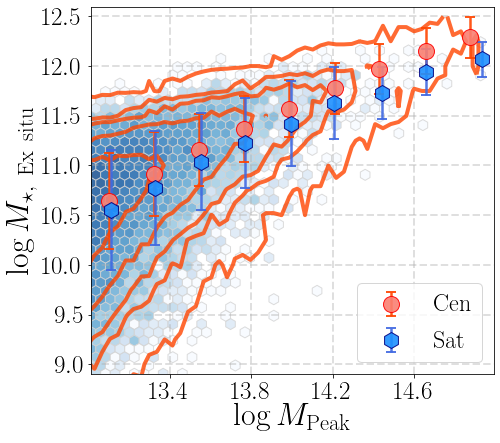

In [32]:
fig_4 = plt.figure(figsize=(7, 6))
fig_4.subplots_adjust(left=0.195, right=0.995, bottom=0.145, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_4.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

ax1.xaxis.set_ticks([13.4, 13.8, 14.2, 14.6])

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

# Centrals
z_stats, x_edges, y_edges = binned_statistic_2d(
    logmh_cen, logms_cen, logms_cen, 'count', bins=(65, 20))

CT = ax1.contour(x_edges[:-1], y_edges[:-1], gaussian_filter(z_stats.T, 0.25),
                 5, linewidths=4, linestyles='solid', 
                 colors=['orangered'], levels=[3, 30, 60, 150, 400],
                 extend='neither', alpha=0.8)

# Satellites
ax1.hexbin(logmh_sat, logms_sat, gridsize=[45, 45], cmap='Blues', edgecolor='lightgray', 
           alpha=0.8, mincnt=1, bins='log')


ax1.errorbar(np.asarray(logmh_avg_cen), np.asarray(logms_avg_cen), yerr=np.asarray(logms_std_cen), fmt='o', 
             ecolor='orangered', elinewidth=2.5, capsize=5, capthick=2.0,
             color='salmon', markersize=16, alpha=0.9,
             markeredgecolor='r', label=r'$\mathrm{Cen}$')

ax1.errorbar(np.asarray(logmh_avg_sat) + 0.01, np.asarray(logms_avg_sat), yerr=np.asarray(logms_std_sat), fmt='h', 
             ecolor='royalblue', elinewidth=2.5, capsize=5, capthick=2.0,
             color='dodgerblue', markersize=16, alpha=0.9,
             markeredgecolor='navy', label=r'$\mathrm{Sat}$')

ax1.legend(loc='lower right', fontsize=24)

ax1.set_xlim(13.01, 14.99)
ax1.set_ylim(8.9, 12.59)

ax1.set_xlabel(r'$\log M_{\mathrm{Peak}}$', fontsize=32)
ax1.set_ylabel(r'$\log M_{\star,\ \rm Ex\ situ}$', fontsize=32)

In [34]:
np.asarray(logms_avg_cen) - np.asarray(logms_avg_sat)

array([       inf, 0.08729444, 0.14103546, 0.12036154, 0.14097659,
       0.15186862, 0.14808952, 0.24675469, 0.21148503, 0.22115194])